# Analytics — Camada SILVER (PostgreSQL → Notebook)

Este notebook lê dados **já tratados na camada SILVER** diretamente do PostgreSQL e gera análises e gráficos.
Tabela esperada:

- **`silver.silver_sinistros`**

Mudanças consideradas (conforme seu ETL):
- `data_inversa` → **`data_acidente`** (DATE)
- `horario` → **`hora_acidente`** (TIME)
- `uso_solo` → **`area_urbana`** (BOOLEAN)
- Não usa `data_hora_acidente`

## 1) Conexão com PostgreSQL

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text

# CONFIG (VS Code / fora do Docker)
# Ajuste aqui se necessário:
os.environ.setdefault("POSTGRES_HOST", "127.0.0.1")
os.environ.setdefault("POSTGRES_PORT", "5433")
os.environ.setdefault("POSTGRES_DB", "sinistros_2025")
os.environ.setdefault("POSTGRES_USER", "postgres")
os.environ.setdefault("POSTGRES_PASSWORD", "dan1920")

user = os.environ["POSTGRES_USER"]
pwd  = os.environ["POSTGRES_PASSWORD"]
host = os.environ["POSTGRES_HOST"]
port = os.environ["POSTGRES_PORT"]
db   = os.environ["POSTGRES_DB"]

engine = create_engine(f"postgresql+psycopg2://{user}:{pwd}@{host}:{port}/{db}", pool_pre_ping=True)
with engine.connect() as conn:
    conn.execute(text("SELECT 1"))

print(f"Conectado! host={host} port={port} db={db} user={user}")

Conectado! host=127.0.0.1 port=5433 db=sinistros_2025 user=postgres


## 2) Checar tabela e colunas

In [2]:
TABLE = "silver.silver_sinistros"

exists = pd.read_sql("""
SELECT EXISTS (
  SELECT 1
  FROM information_schema.tables
  WHERE table_schema='silver' AND table_name='silver_sinistros'
) AS ok
""", engine)

exists

,ok
0,True


In [3]:
if not bool(exists.loc[0, "ok"]):
    raise RuntimeError("Não encontrei a tabela silver.silver_sinistros. Rode o ETL RAW→SILVER antes.")

cols = pd.read_sql("""
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_schema='silver' AND table_name='silver_sinistros'
ORDER BY ordinal_position
""", engine)

colnames = cols["column_name"].tolist()
cols

,column_name,data_type
0,id,bigint
1,data_acidente,date
2,dia_semana,text
3,hora_acidente,time without time zone
4,uf,text
5,br,text
6,municipio,text
7,causa_acidente,text
8,tipo_acidente,text
9,classificacao_acidente,text


## 3) Visão geral (volume, período, mortos/feridos)

In [4]:
overview = pd.read_sql("""
SELECT
  COUNT(*)::bigint AS acidentes,
  COALESCE(SUM(mortos),0)::bigint AS mortos,
  COALESCE(SUM(feridos),0)::bigint AS feridos,
  MIN(data_acidente) AS inicio,
  MAX(data_acidente) AS fim
FROM silver.silver_sinistros
""", engine)

overview

,acidentes,mortos,feridos,inicio,fim
0,65683,5466,75378,2025-01-01,2025-12-11


## 4) Qualidade (nulos por coluna)

In [5]:
# Nulos via SQL (evita puxar tudo)
parts = [f"SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END)::bigint AS null_{c}" for c in colnames]
sql = "SELECT\n  " + ",\n  ".join(parts) + f"\nFROM {TABLE}"

nulls = pd.read_sql(sql, engine).T.reset_index()
nulls.columns = ["coluna", "n_nulos"]
nulls["coluna"] = nulls["coluna"].str.replace("null_", "", regex=False)
nulls = nulls.sort_values("n_nulos", ascending=False)
nulls.head(25)

,coluna,n_nulos
1,data_acidente,39678
9,classificacao_acidente,1
0,id,0
3,hora_acidente,0
4,uf,0
5,br,0
2,dia_semana,0
6,municipio,0
7,causa_acidente,0
8,tipo_acidente,0


## 5) Ranking por UF / Município / BR

In [6]:
uf = pd.read_sql("""
SELECT
  uf,
  COUNT(*)::bigint AS total_acidentes,
  COALESCE(SUM(mortos),0)::bigint AS total_mortos,
  COALESCE(SUM(feridos),0)::bigint AS total_feridos
FROM silver.silver_sinistros
GROUP BY uf
ORDER BY total_acidentes DESC
""", engine)

uf.head(20)

,uf,total_acidentes,total_mortos,total_feridos
0,MG,8679,691,10782
1,SC,7390,401,8474
2,PR,6933,552,7725
3,RJ,5749,304,6866
4,RS,4434,286,4964
5,SP,4264,189,4506
6,BA,3759,529,4585
7,GO,2869,260,3171
8,PE,2686,309,2978
9,MT,2415,231,2562


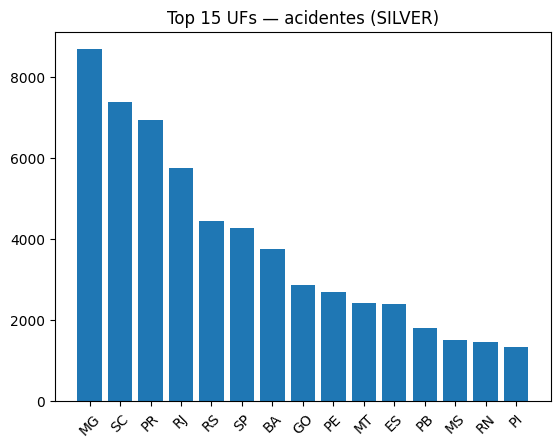

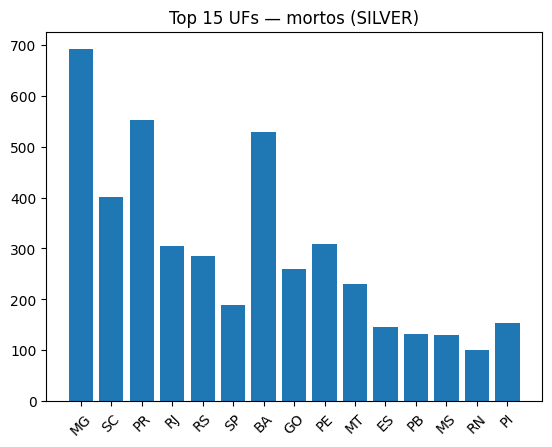

In [7]:
import matplotlib.pyplot as plt

top_uf = uf.head(15).copy()
plt.figure()
plt.bar(top_uf["uf"].astype(str), top_uf["total_acidentes"])
plt.title("Top 15 UFs — acidentes (SILVER)")
plt.xticks(rotation=45)
plt.show()

plt.figure()
plt.bar(top_uf["uf"].astype(str), top_uf["total_mortos"])
plt.title("Top 15 UFs — mortos (SILVER)")
plt.xticks(rotation=45)
plt.show()

In [8]:
top_municipios = pd.read_sql("""
SELECT
  municipio,
  COUNT(*)::bigint AS total_acidentes,
  COALESCE(SUM(mortos),0)::bigint AS total_mortos
FROM silver.silver_sinistros
GROUP BY municipio
ORDER BY total_acidentes DESC
LIMIT 20
""", engine)

top_municipios

,municipio,total_acidentes,total_mortos
0,BRASILIA,926,43
1,DUQUE DE CAXIAS,755,24
2,GUARULHOS,697,19
3,SAO JOSE,678,12
4,CURITIBA,637,28
5,BETIM,618,18
6,SERRA,529,19
7,RECIFE,528,26
8,PALHOCA,511,12
9,JOAO PESSOA,498,17


In [9]:
if "br" in colnames:
    top_brs = pd.read_sql("""
    SELECT
      br,
      COUNT(*)::bigint AS total_acidentes,
      COALESCE(SUM(mortos),0)::bigint AS total_mortos
    FROM silver.silver_sinistros
    WHERE br IS NOT NULL
    GROUP BY br
    ORDER BY total_acidentes DESC
    LIMIT 20
    """, engine)
    top_brs
else:
    print("Coluna 'br' não existe na SILVER.")

## 6) Séries temporais (por dia e por mês)

In [10]:
diario = pd.read_sql("""
SELECT
  data_acidente AS dia,
  COUNT(*)::bigint AS acidentes,
  COALESCE(SUM(mortos),0)::bigint AS mortos
FROM silver.silver_sinistros
WHERE data_acidente IS NOT NULL
GROUP BY dia
ORDER BY dia
""", engine)

diario.head()

,dia,acidentes,mortos
0,2025-01-01,193,14
1,2025-01-02,187,21
2,2025-01-03,246,18
3,2025-01-04,138,4
4,2025-01-05,175,21


In [12]:
mensal = pd.read_sql("""
SELECT
  DATE_TRUNC('month', data_acidente::timestamp)::date AS mes,
  COUNT(*)::bigint AS acidentes,
  COALESCE(SUM(mortos),0)::bigint AS mortos
FROM silver.silver_sinistros
WHERE data_acidente IS NOT NULL
GROUP BY mes
ORDER BY mes
""", engine)

mensal

,mes,acidentes,mortos
0,2025-01-01,2114,171
1,2025-02-01,2130,197
2,2025-03-01,2011,167
3,2025-04-01,2158,164
4,2025-05-01,2149,191
5,2025-06-01,2115,174
6,2025-07-01,2197,171
7,2025-08-01,2219,217
8,2025-09-01,2289,184
9,2025-10-01,2188,188


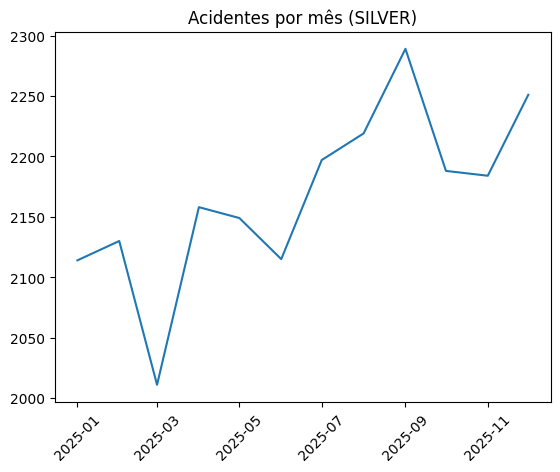

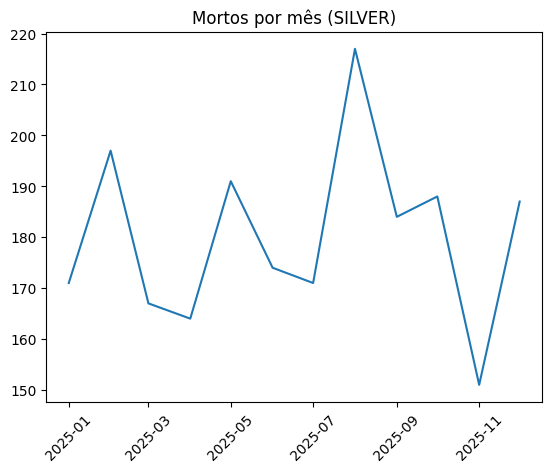

In [13]:
plt.figure()
plt.plot(mensal["mes"], mensal["acidentes"])
plt.title("Acidentes por mês (SILVER)")
plt.xticks(rotation=45)
plt.show()

plt.figure()
plt.plot(mensal["mes"], mensal["mortos"])
plt.title("Mortos por mês (SILVER)")
plt.xticks(rotation=45)
plt.show()

## 7) Hora do dia / Dia da semana / Fase do dia

In [14]:
if "hora_acidente" in colnames:
    por_hora = pd.read_sql("""
    SELECT
      EXTRACT(HOUR FROM hora_acidente)::int AS hora,
      COUNT(*)::bigint AS acidentes,
      COALESCE(SUM(mortos),0)::bigint AS mortos
    FROM silver.silver_sinistros
    WHERE hora_acidente IS NOT NULL
    GROUP BY hora
    ORDER BY hora
    """, engine)
    por_hora
else:
    print("Coluna 'hora_acidente' não existe.")

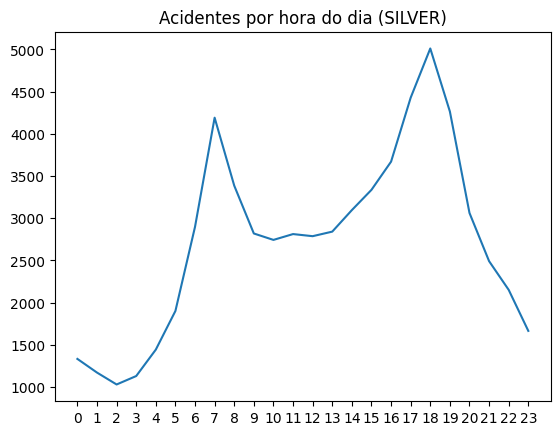

In [15]:
import matplotlib.pyplot as plt

if "hora_acidente" in colnames:
    plt.figure()
    plt.plot(por_hora["hora"], por_hora["acidentes"])
    plt.title("Acidentes por hora do dia (SILVER)")
    plt.xticks(range(0,24))
    plt.show()

In [16]:
if "dia_semana" in colnames:
    por_dia_semana = pd.read_sql("""
    SELECT
      dia_semana,
      COUNT(*)::bigint AS acidentes,
      COALESCE(SUM(mortos),0)::bigint AS mortos
    FROM silver.silver_sinistros
    GROUP BY dia_semana
    ORDER BY acidentes DESC
    """, engine)
    por_dia_semana
else:
    print("Coluna 'dia_semana' não existe.")

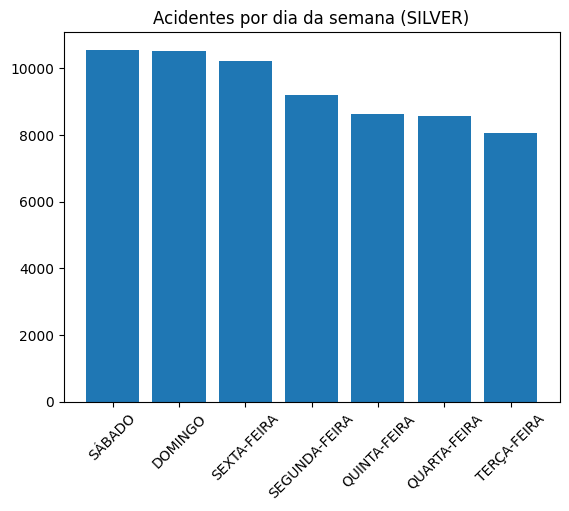

In [17]:
if "dia_semana" in colnames:
    plt.figure()
    plt.bar(por_dia_semana["dia_semana"].astype(str), por_dia_semana["acidentes"])
    plt.title("Acidentes por dia da semana (SILVER)")
    plt.xticks(rotation=45)
    plt.show()

In [18]:
if "fase_dia" in colnames:
    por_fase = pd.read_sql("""
    SELECT
      fase_dia,
      COUNT(*)::bigint AS acidentes,
      COALESCE(SUM(mortos),0)::bigint AS mortos
    FROM silver.silver_sinistros
    GROUP BY fase_dia
    ORDER BY acidentes DESC
    """, engine)
    por_fase
else:
    print("Coluna 'fase_dia' não existe.")

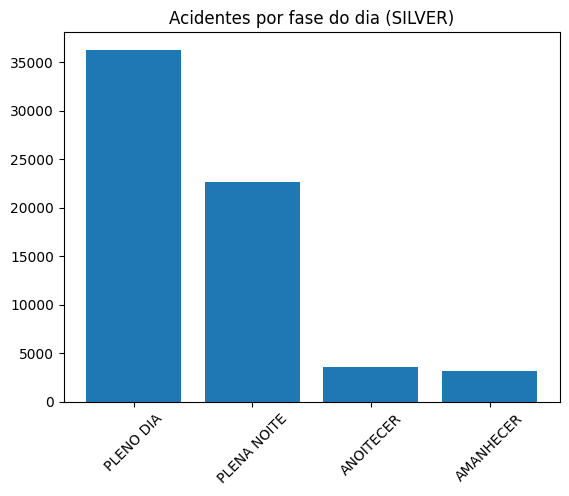

In [19]:
if "fase_dia" in colnames:
    plt.figure()
    plt.bar(por_fase["fase_dia"].astype(str), por_fase["acidentes"])
    plt.title("Acidentes por fase do dia (SILVER)")
    plt.xticks(rotation=45)
    plt.show()

## 8) Causas / Tipos / Condições externas

In [20]:
def top20(col):
    if col not in colnames:
        print(f"Coluna ausente: {col}")
        return None
    q = f"""
    SELECT
      {col} AS categoria,
      COUNT(*)::bigint AS acidentes,
      COALESCE(SUM(mortos),0)::bigint AS mortos
    FROM silver.silver_sinistros
    GROUP BY {col}
    ORDER BY acidentes DESC
    LIMIT 20
    """
    return pd.read_sql(q, engine)

top_causa = top20("causa_acidente")
top_tipo  = top20("tipo_acidente")
top_clima = top20("condicao_metereologica")
top_pista = top20("tipo_pista")

top_causa, top_tipo, top_clima, top_pista

(                                            categoria  acidentes  mortos
 0                      AUSÊNCIA DE REAÇÃO DO CONDUTOR      10322     761
 1            REAÇÃO TARDIA OU INEFICIENTE DO CONDUTOR       9732     529
 2   ACESSAR A VIA SEM OBSERVAR A PRESENÇA DOS OUTR...       6459     386
 3   CONDUTOR DEIXOU DE MANTER DISTÂNCIA DO VEÍCULO...       4028      85
 4                             VELOCIDADE INCOMPATÍVEL       3683     439
 5                         MANOBRA DE MUDANÇA DE FAIXA       3657     165
 6                    INGESTÃO DE ÁLCOOL PELO CONDUTOR       3354     204
 7                DEMAIS FALHAS MECÂNICAS OU ELÉTRICAS       3063      53
 8                              TRANSITAR NA CONTRAMÃO       2234     853
 9                                   CONDUTOR DORMINDO       1916     161
 10                             ULTRAPASSAGEM INDEVIDA       1588     365
 11  TRAFEGAR COM MOTOCICLETA (OU SIMILAR) ENTRE AS...       1206      53
 12                                   

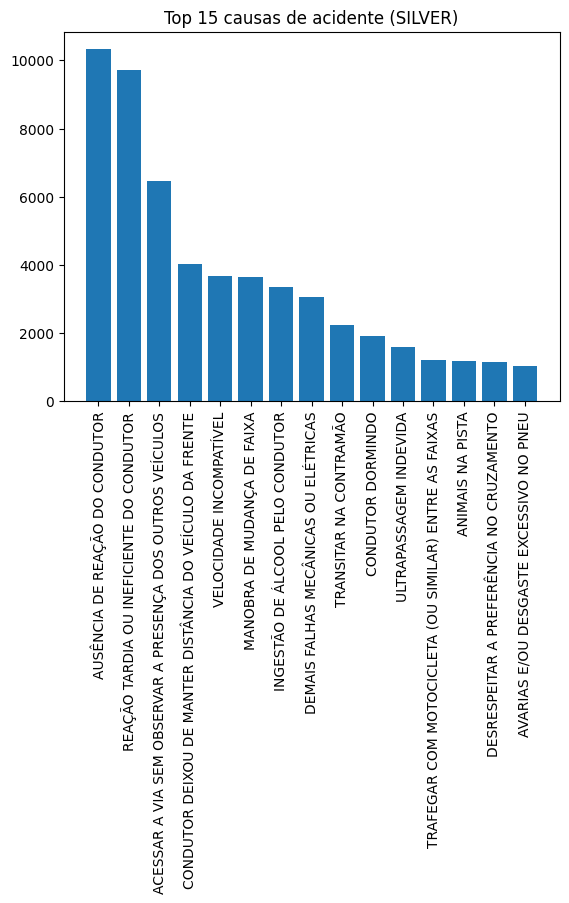

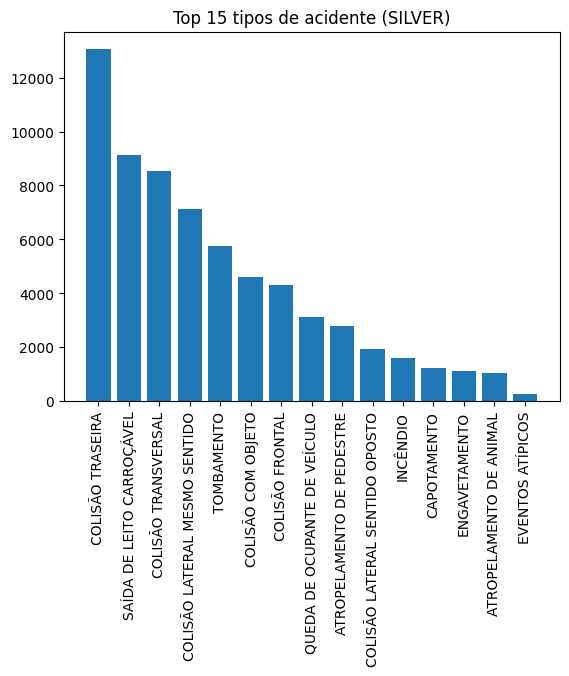

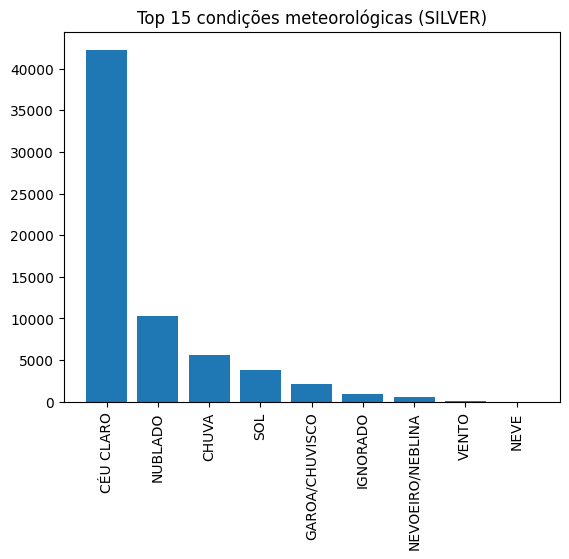

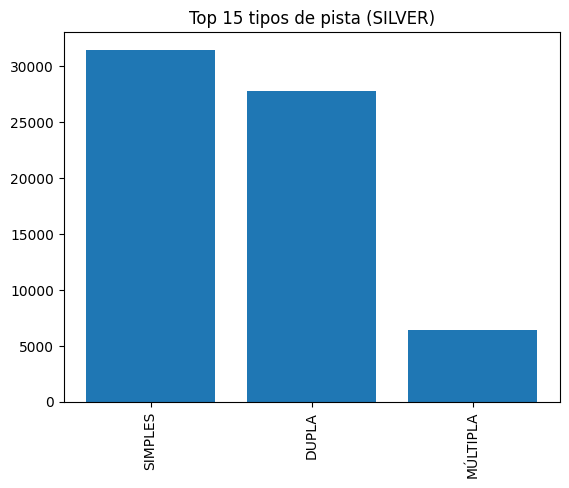

In [21]:
import matplotlib.pyplot as plt

def plot_top(df, title):
    if df is None or df.empty:
        return
    d = df.head(15).copy()
    plt.figure()
    plt.bar(d["categoria"].astype(str), d["acidentes"])
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_top(top_causa, "Top 15 causas de acidente (SILVER)")
plot_top(top_tipo,  "Top 15 tipos de acidente (SILVER)")
plot_top(top_clima, "Top 15 condições meteorológicas (SILVER)")
plot_top(top_pista, "Top 15 tipos de pista (SILVER)")

## 9) Área urbana (boolean)

In [22]:
if "area_urbana" in colnames:
    urb = pd.read_sql("""
    SELECT
      area_urbana,
      COUNT(*)::bigint AS acidentes,
      COALESCE(SUM(mortos),0)::bigint AS mortos
    FROM silver.silver_sinistros
    GROUP BY area_urbana
    ORDER BY acidentes DESC
    """, engine)
    urb
else:
    print("Coluna 'area_urbana' não existe.")

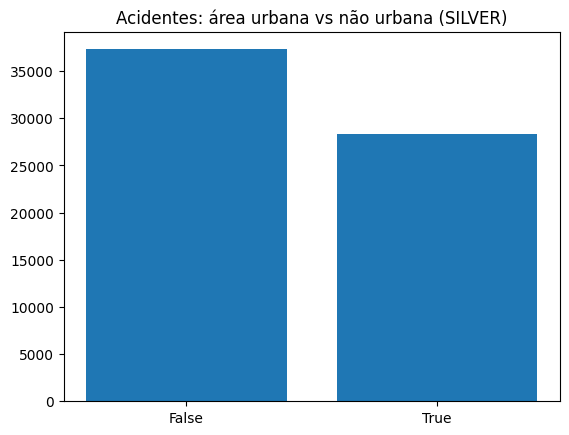

In [23]:
import matplotlib.pyplot as plt

if "area_urbana" in colnames:
    plt.figure()
    plt.bar(urb["area_urbana"].astype(str), urb["acidentes"])
    plt.title("Acidentes: área urbana vs não urbana (SILVER)")
    plt.show()

## 10) KPIs de severidade (simples)

In [24]:
severidade = pd.read_sql("""
SELECT
  COUNT(*)::bigint AS acidentes_total,
  SUM(CASE WHEN COALESCE(mortos,0) > 0 THEN 1 ELSE 0 END)::bigint AS acidentes_com_mortos,
  ROUND(
    CASE WHEN COUNT(*)>0
      THEN (SUM(CASE WHEN COALESCE(mortos,0) > 0 THEN 1 ELSE 0 END)::numeric / COUNT(*))
      ELSE 0
    END
  , 6) AS taxa_acidente_com_morto,
  COALESCE(SUM(mortos),0)::bigint AS mortos_total,
  ROUND(
    CASE WHEN COUNT(*)>0 THEN (COALESCE(SUM(mortos),0)::numeric / COUNT(*)) ELSE 0 END
  , 6) AS mortos_por_acidente
FROM silver.silver_sinistros
""", engine)

severidade

,acidentes_total,acidentes_com_mortos,taxa_acidente_com_morto,mortos_total,mortos_por_acidente
0,65683,4726,0.071952,5466,0.083218


## 11) Export (opcional)

In [25]:
# Exemplos:
# uf.to_csv("silver_uf.csv", index=False)
# mensal.to_csv("silver_mensal.csv", index=False)
# top_causa.to_csv("silver_top_causa.csv", index=False)

print("Concluído.")

Concluído.
